In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

# Исследование данных

## Загрузка данных

In [2]:
# load the data
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/submission.csv')

# Check random row
random_number_train = np.random.randint(data_train.shape[0])
random_number_test = np.random.randint(data_test.shape[0])
#print(data_train.iloc[random_number_train])
#print(data_test.iloc[random_number_test])

# Select target
y_train = data_train.Churn

# Select features
X_train = data_train.drop('Churn', axis=1)
X_test = data_test

#Check missing values
#X_train.info()
#X_test.info()

cols_with_missing_X_train = [col for col in X_train
                     if X_train[col].isnull().any() or (X_train[col] == ' ').any()]
cols_with_missing_X_test = [col for col in X_test
                     if X_test[col].isnull().any() or (X_test[col] == ' ').any()]
#print('Cols with missing values in X_train:', cols_with_missing_X_train)
#print('Cols with missing values in X_test:', cols_with_missing_X_test)

# Imputation
def to_float_TotalSpent(data: pd.DataFrame) -> pd.DataFrame:
    """
    Get DataFrame and converts the TotalSpent column to float 
    empty values = np.nan
    """
    for i, val in enumerate(data.TotalSpent):
        if val == ' ':
            data.TotalSpent.iloc[i] = np.nan
    data = data.astype({'TotalSpent': 'float64'})
    return data

X_train = to_float_TotalSpent(X_train)
X_test = to_float_TotalSpent(X_test)

#print(X_train[X_train['TotalSpent'].isna()])
print(X_train.isna().sum())

TotalSpent_X_train = np.array(X_train.TotalSpent).reshape(-1, 1)
TotalSpent_X_test = np.array(X_test.TotalSpent).reshape(-1, 1)

my_imputer = SimpleImputer()
imputed_TotalSpent_X_train = pd.DataFrame(my_imputer.fit_transform(TotalSpent_X_train))
imputed_TotalSpent_X_test = pd.DataFrame(my_imputer.transform(TotalSpent_X_test))

# Imputation removed column names: put the back and add in main DataFrame
imputed_TotalSpent_X_train.columns = ['TotalSpent']
imputed_TotalSpent_X_test.columns = ['TotalSpent']
X_train.TotalSpent = imputed_TotalSpent_X_train
X_test.TotalSpent = imputed_TotalSpent_X_test

# Find numerical and categorical columns
numerical_columns = [col for col in X_train
                     if X_train[col].dtypes in ['int64', 'float64']]
numerical_columns.remove('IsSeniorCitizen')
categorical_columns = [col for col in X_train
                       if X_train[col].dtypes == 'object']
categorical_columns.append('IsSeniorCitizen')

ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
dtype: int64


## Анализ данных

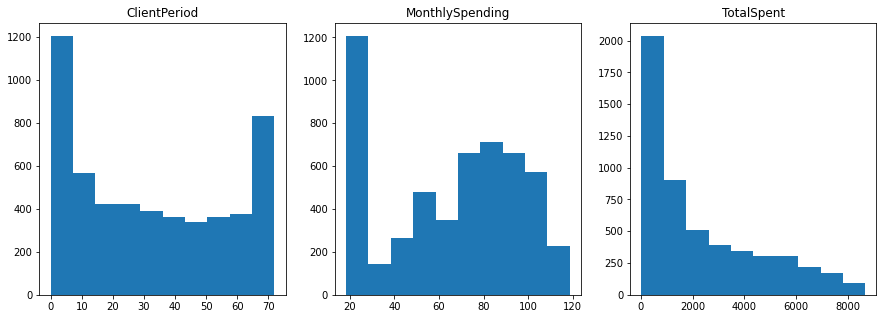

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax = ax.ravel()

for i, column in enumerate(numerical_columns):
    ax[i].set_title(column)
    ax[i].hist(X_train[column])
    
fig.show()

### Я попробовал проанализировать графики и думаю дела обстоят так:
##### -График ClientPeriod - думаю, эта калонка показывает сколько дней клиент пользуется услугами компании. Диапазон баров ~ 5. Получается у компании много новичков, которые держатся до 5 дней, после 5 дней примерно половина клиентов отключаются. Потеря клиентов идет до ~ 45-50 дней, после этого клиенты ,как правило, остаются.
##### -График  MonthlySpending - Ежемесячные расходы. диапазон баров ~ 10. Больше всего рассходов уходит на 20-30
##### -График TotalSpent - Всего потрачено. диапазон баров ~ 1000. Большая часть людей тратят ~ 1000 и чем больше эта цифра, тем меньше людей, что логично, ведь большие суммы тратят меньшее количество людей


## Bar chart for categorical columns

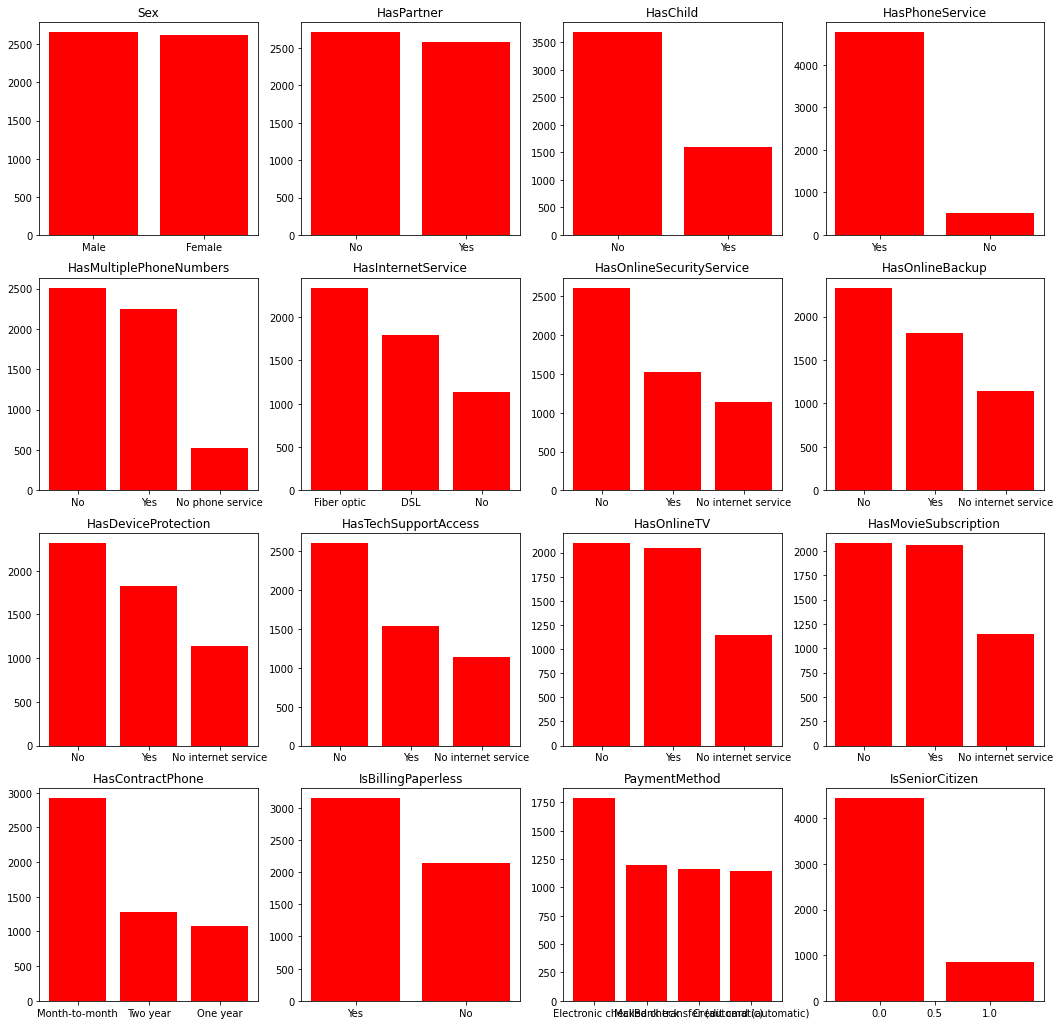

In [79]:
fig, ax = plt.subplots(4, 4, figsize=(18,18))

ax = ax.ravel()

for i, col in enumerate(categorical_columns):
    ax[i].set_title(col)
    x = X_train[col].value_counts()
    ax[i].bar(x.keys(), x, color='red')
fig.show()

#### Уникальных значений мало, поэтому перед обучением модели будем использовать hot-encoding для категориальных данных
#### По диаграммам можно сделать вывод, что в основном значения приблизительно равны,  большие различия имеют только:
#### HasChild, HasPhoneService, IsSeniorCitizen, остальные либо примерно равны, либо часть из них равна.

## Pie chart for categorical columns

In [81]:
#fig, ax = plt.subplots(4, 4, figsize=(18,18))

#ax = ax.ravel()

#for i, col in enumerate(categorical_columns):
    #ax[i].set_title(col)
    #x = X_train[col].value_counts()
    #ax[i].pie(x, labels = x.keys())
#fig.show()

### Распределение целевой переменной (проверка на сбалансированность классов)

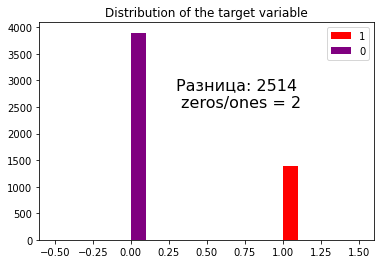

In [134]:
units = [one for one in y_train
         if one == 1]
zeros = [zero for zero in y_train
         if zero == 0]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.set_title('Distribution of the target variable')
ax.hist(units, color='red', label='1')
ax.hist(zeros, color='purple', label='0')
ax.legend()
ax.text(0.30, 2500, f'Разница: {len(zeros) - len(ones)} \n zeros/ones = {len(zeros) // len(ones)}', size=16)

fig.show()

#### Классов "0" в 2 раза больше, чем классов "1". Это не такая большая разница, поэтому делаем вывод, что классы сбалансированы.